# Проект: Прогнозирование оттока клиентов оператора связи

## Описание проекта
Оператор связи «ТелеДом» стремится снизить отток клиентов, предлагая промокоды и специальные условия тем, кто планирует отказаться от услуг. Для этого необходима модель, предсказывающая вероятность расторжения договора. Данные включают персональную информацию клиентов, сведения о тарифах и услугах.

## Описание услуг
- **Стационарная связь**: возможность подключения нескольких линий.
- **Интернет**:
  - DSL (цифровая абонентская линия).
  - Оптоволоконное подключение.
- **Дополнительные услуги**:
  - Антивирус (DeviceProtection) и блокировка сайтов (OnlineSecurity).
  - Выделенная техподдержка (TechSupport).
  - Облачное хранилище (OnlineBackup).
  - Стриминговое ТВ (StreamingTV) и каталог фильмов (StreamingMovies).
- **Оплата**:
  - Ежемесячная или раз в 1–2 года.
  - Разные способы оплаты, электронные чеки.

## Описание данных
### Источники:
1. **contract_new.csv**: информация о договоре.
2. **personal_new.csv**: персональные данные клиента.
3. **internet_new.csv**: информация об интернет-услугах.
4. **phone_new.csv**: информация об услугах телефонии.

### Основные столбцы:
- **contract_new.csv**:
  - `customerID` — идентификатор клиента.
  - `BeginDate`, `EndDate` — даты действия договора.
  - `Type` — тип оплаты.
  - `MonthlyCharges`, `TotalCharges` — расходы клиента.
- **personal_new.csv**:
  - `gender` — пол.
  - `SeniorCitizen` — пенсионер.
  - `Partner`, `Dependents` — наличие супруга(и) или детей.
- **internet_new.csv**:
  - `InternetService` — тип подключения.
  - Услуги: `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`.
- **phone_new.csv**:
  - `MultipleLines` — подключение нескольких линий.

Все файлы содержат столбец `customerID` для объединения данных.

## План работы
1. **Загрузка данных**:
   - Загрузка и первичный осмотр.
2. **Исследовательский анализ и предобработка**:
   - Анализ каждого набора данных, выбор необходимых признаков.
3. **Объединение данных**:
   - Объединение по ключу `customerID`.
4. **Анализ объединённого датафрейма**:
   - Визуализация распределений, корреляционный анализ, генерация новых признаков.
5. **Подготовка данных**:
   - Деление на выборки, масштабирование и кодирование.
6. **Обучение моделей**:
   - Обучение минимум двух моделей, настройка гиперпараметров.
7. **Выбор лучшей модели**:
   - Оценка на тестовой выборке.
8. **Выводы и рекомендации**:
   - Основные результаты и бизнес-рекомендации.

In [1]:
!pip install phik shap scikit-learn==1.5.2 --quiet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.utils import shuffle

In [3]:
RANDOM_STATE = 130125

### 1. Загрузка данных

In [4]:
try:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
except FileNotFoundError:
    print("Ошибка загрузки данных")

In [5]:
# Первичный осмотр данных
for data in [contract, personal, internet, phone]:
    display(data.describe())
    display(data.info())
    display(data.head())
    print("--------------------")

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


--------------------


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


--------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


--------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


--------------------


Данные успешно загружены. Поменяем типы данных у столбцов с датами.

In [6]:
# Замена типов данных в contract
contract['EndDate'] = contract['EndDate'].replace('No', pd.NaT)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

### 2. Исследовательский анализ и предобработка

In [7]:
# Проверка на дубликаты
for data in [contract, personal, internet, phone]:
    print(data.duplicated().sum())

0
0
0
0


Дубликатов нет. Проверим на пропуски.

In [8]:
# Проверка на пропуски
for data in [contract, personal, internet, phone]:
    print(data.isna().sum())

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
customerID       0
MultipleLines    0
dtype: int64


Пропуски есть только в EndDate в contract, так как No означает, что договор ещё действует. Пропусков в остальных данных нет. Посмотрим на уникальные значения.

In [9]:
# Уникальные значения
for data in [contract, personal, internet, phone]:
    print(data.nunique())
    print("--------------------")

customerID          7043
BeginDate             77
EndDate               66
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6657
dtype: int64
--------------------
customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64
--------------------
customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64
--------------------
customerID       6361
MultipleLines       2
dtype: int64
--------------------


Неявные дубликаты отсутствуют.

### 3. Объединение данных

Проверим количество уникальных значений в столбце customerID.

In [10]:
for data in [contract, personal, internet, phone]:
    print(data['customerID'].nunique())

7043
7043
5517
6361


После объединения данных по ключу customerID, у нас останется 7043 уникальных клиента

In [11]:
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')

# Если EndDate = NaT, то договор ещё действует. Создадим новый признак contractIsOver. (0 - действует, 1 - закончился)
df['contractIsOver'] = df['EndDate'].notna().astype(int)

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractIsOver
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Данные успешно объединены. Количество строк - 7043, столбцов - 20.

### 4. Исследовательский анализ объединённого датафрейма

Заполним пропуски в данных.

In [13]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
contractIsOver         0
dtype: int64

In [14]:
df['EndDate'] = df['EndDate'].fillna('Active')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])
df['InternetService'] = df['InternetService'].fillna('No')

internet_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_columns:
    df.loc[df['InternetService'] == 'No', col] = 'No'  # У клиентов без интернета услуга отсутствует
    df.loc[df['InternetService'] != 'No', col] = df[col].fillna(df[col].mode()[0])  # Если интернет есть заполняем модой

df['MultipleLines'] = df['MultipleLines'].fillna('No phone service')

In [15]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
contractIsOver      0
dtype: int64

Создадим новые признаки:
- `ContractDays` - длительность использования услуг (только для активных договоров).
- `ContractMonths` - длительность использования услуг в месяцах.
- `ContractYears` - длительность использования услуг в годах.
- `DailyCharges` - средние расходы на день.
- `YearlyCharges` - годовые расходы.
- `NumServices` - количество подключенных услуг.
- `IsFiberOptic` - использует ли клиент оптоволоконное подключение.
- `HighSpender` - тратит ли клиент больше медианы на услуги.
- `PaymentTerm` - сегментация по графику оплаты.

In [16]:
# Заменяем 'Active' в EndDate на дату выгрузки
export_date = pd.Timestamp('2020-02-01')
df.loc[df['EndDate'] == 'Active', 'EndDate'] = export_date
df['EndDate'] = pd.to_datetime(df['EndDate'])

# Вычисляем длительность использования услуг
df['ContractDays'] = (df['EndDate'] - df['BeginDate']).dt.days
df['ContractMonths'] = df['ContractDays'] // 30
df['ContractYears'] = df['ContractDays'] // 365

# Средние расходы на день и год
df['DailyCharges'] = df['MonthlyCharges'] / 30
df['YearlyCharges'] = df['MonthlyCharges'] * 12

# Количество подключенных услуг
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

df['NumServices'] = df[service_columns].apply(
    lambda row: sum(val == 'Yes' for val in row),
    axis=1
)

# Использует ли клиент оптоволоконное подключение
df['IsFiberOptic'] = (df['InternetService'] == 'Fiber optic').astype(int)

# Тратит ли клиент больше медианы на услуги
df['HighSpender'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)

# Сегментация по графику оплаты
df['PaymentTerm'] = df['Type'].map({
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
})

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,contractIsOver,ContractDays,ContractMonths,ContractYears,DailyCharges,YearlyCharges,NumServices,IsFiberOptic,HighSpender,PaymentTerm
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,0,31,1,0,0.995000,358.2,1,0,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,0,1036,34,2,1.898333,683.4,2,0,0,1
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,0,123,4,0,1.795000,646.2,2,0,0,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,0,1371,45,3,1.410000,507.6,3,0,0,1
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,0,153,5,0,2.356667,848.4,0,1,1,0


In [17]:
#Код ментора
pd.Timestamp.now()

Timestamp('2025-01-17 19:49:27.665053')

Визуализируем числовые признаки.

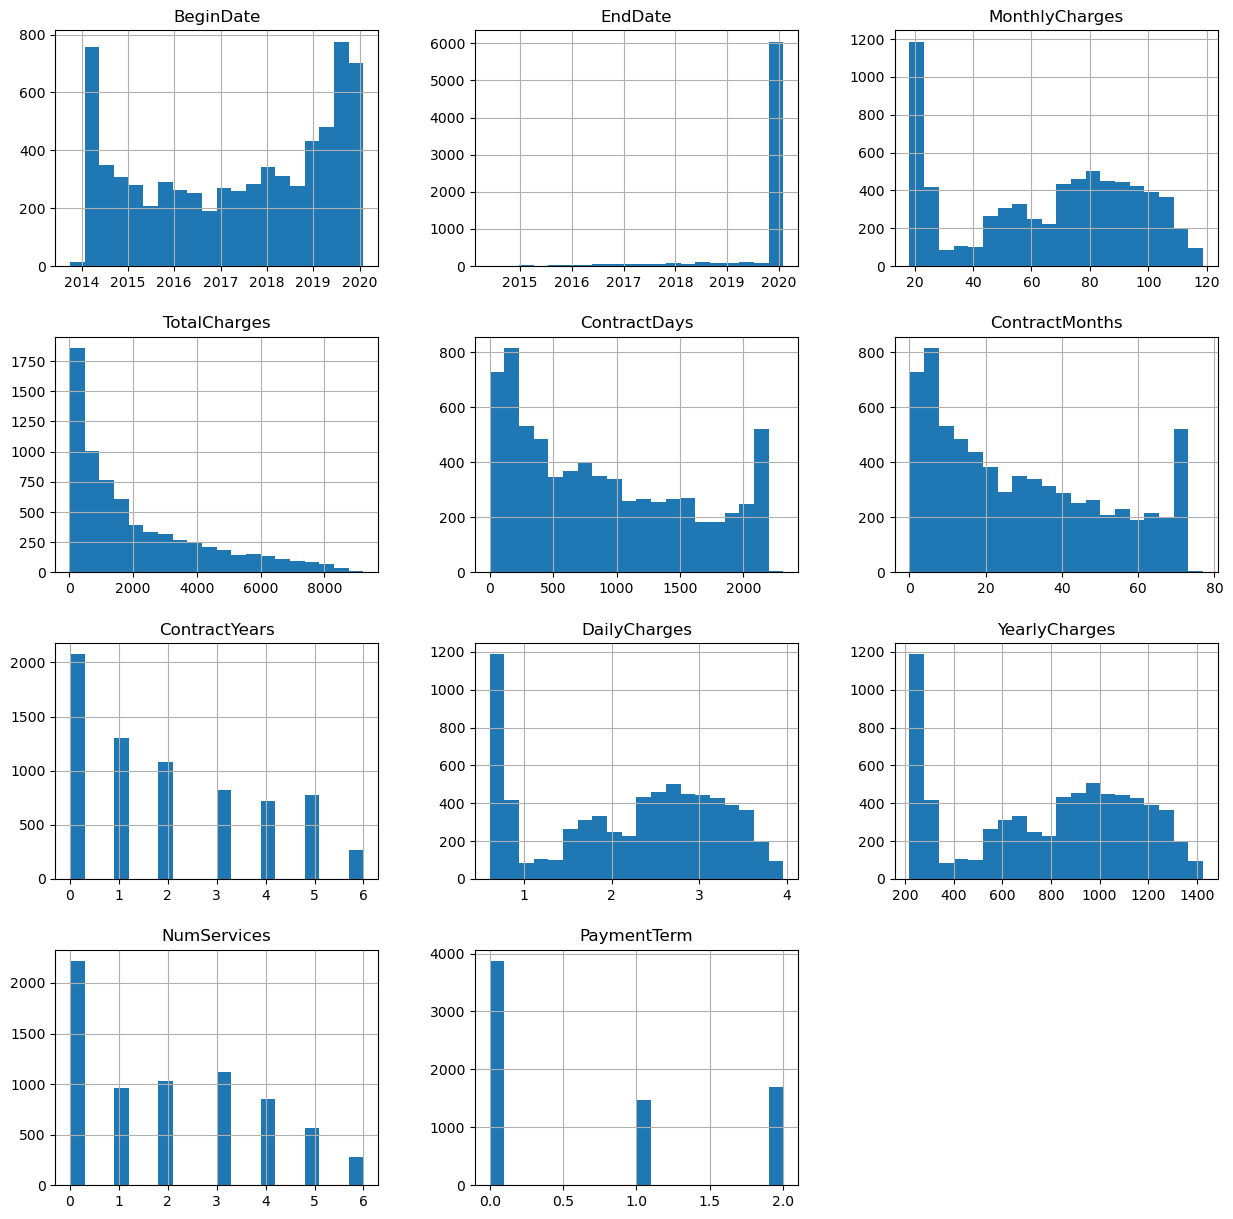

In [18]:
numerical_columns = df.select_dtypes(include=['number', 'datetime']).columns
filtered_columns = [col for col in numerical_columns if df[col].nunique() > 2]

df[filtered_columns].hist(figsize=(15, 15), bins=20)
plt.show()

В 2019-2020 произошёл всплеск количества новых клиентов. В это время увеличилось количество заключённых договоров на месяц. Средние расходы клиентов варьируются от 20 до 120 долларов. Большинство клиентов не пользуются дополнитель

Рассмотрим месячные расходы клиентов. Пик приходится на 20-30 долларов (?). Скорее всего большинство пользователей пользуются базовыми тарифами. Также много клиентов с месячными расходами около 70 долларов.

Рассмотрим годовые расходы клиентов. Пик приходится на 1000-2000 долларов (?). Скорее всего это клиенты, которые заключили договор сразу на несколько лет.

Пики длительности договоров приходятся на 5 и 10 лет.

Чаще всего клиенты тратят в год около 200 долларов.

Большинство клиентов не пользуются дополнительными услугами

Визуализируем категориальные признаки.

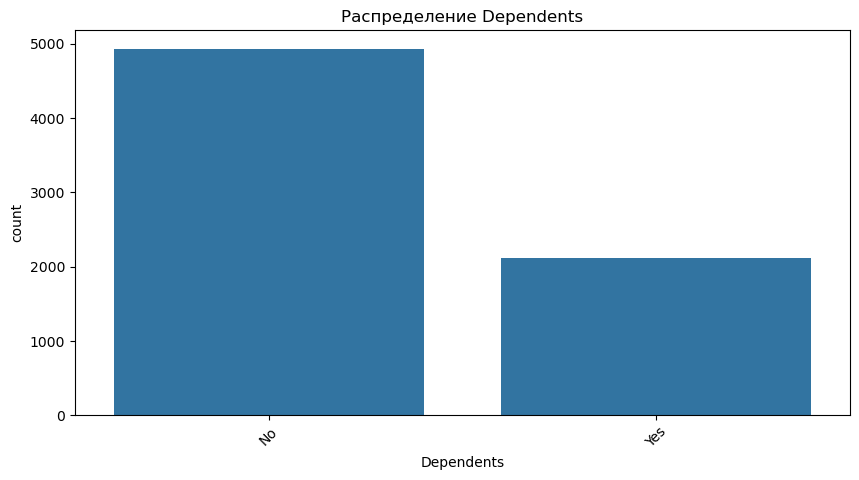

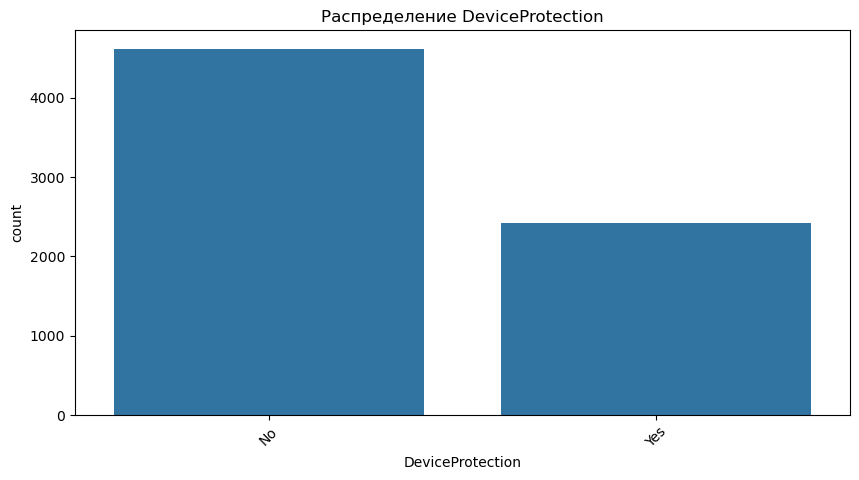

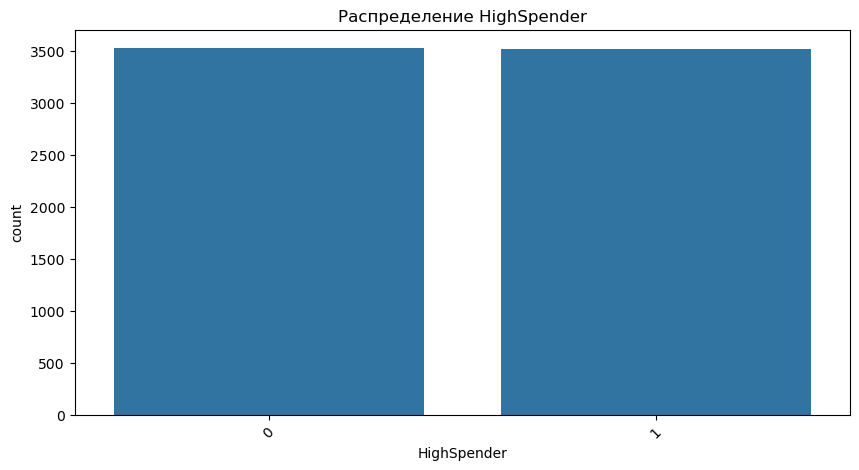

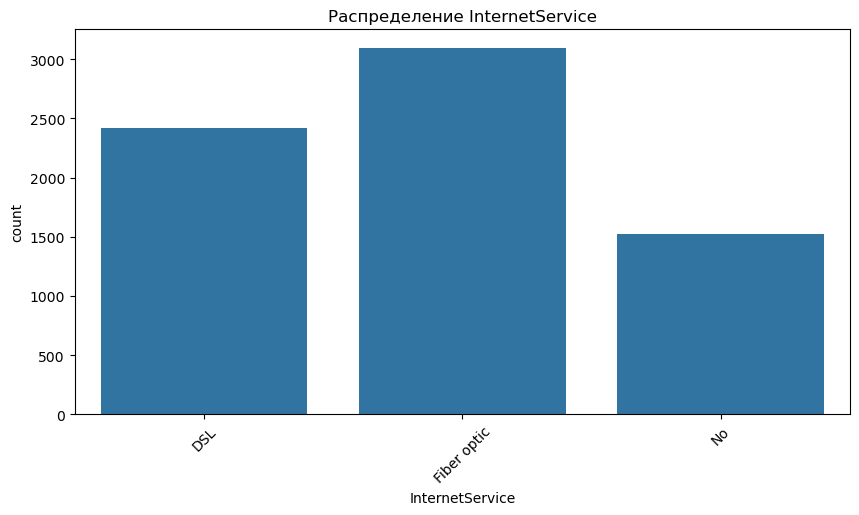

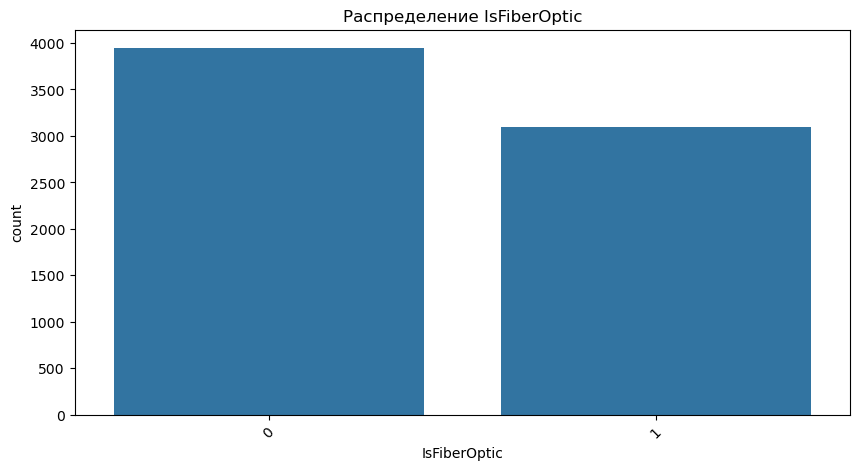

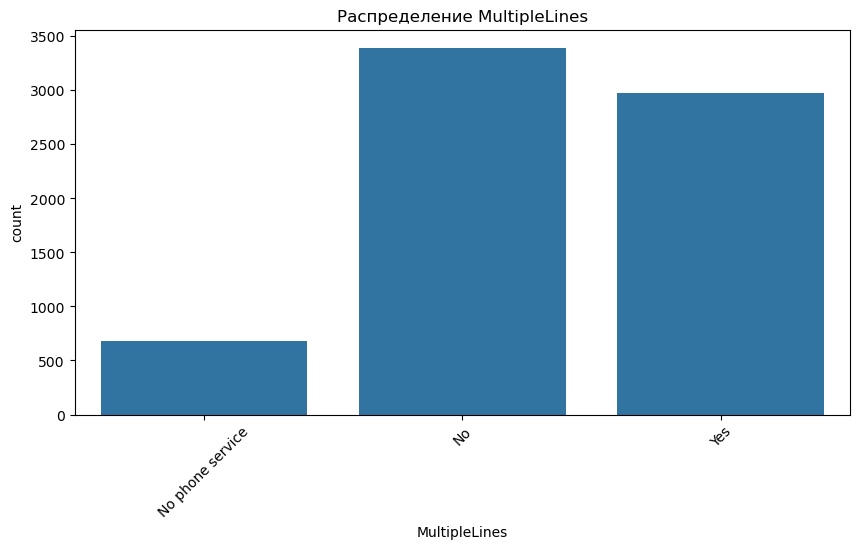

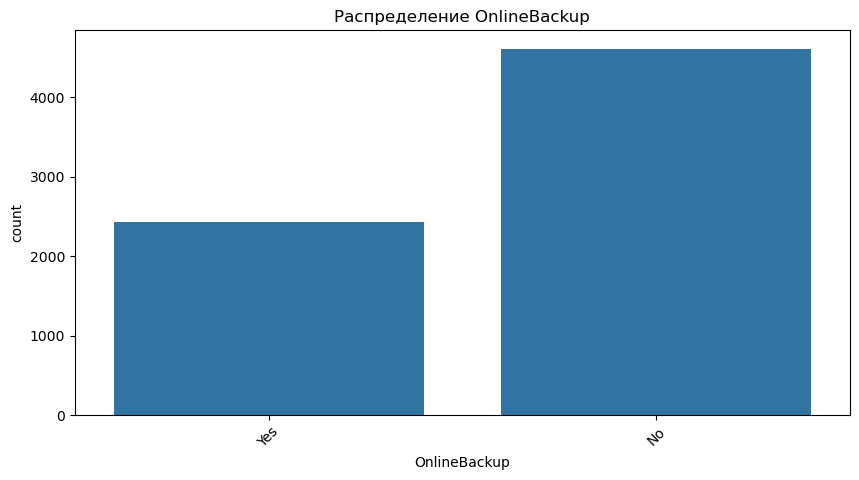

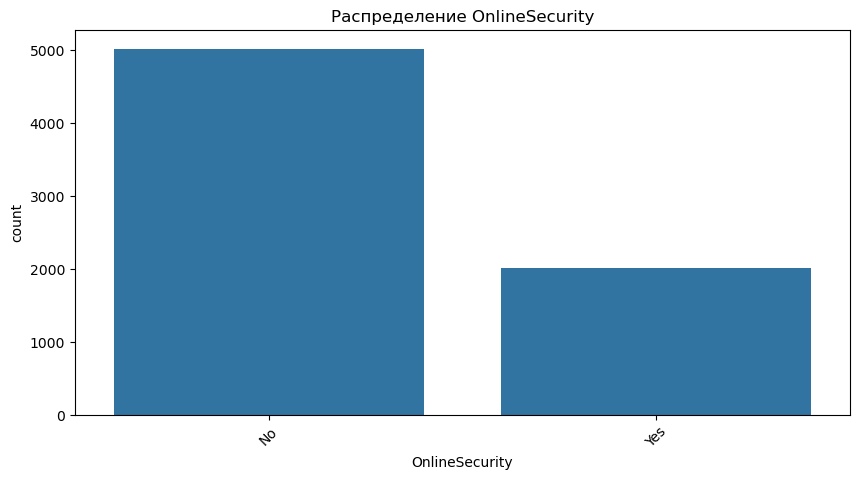

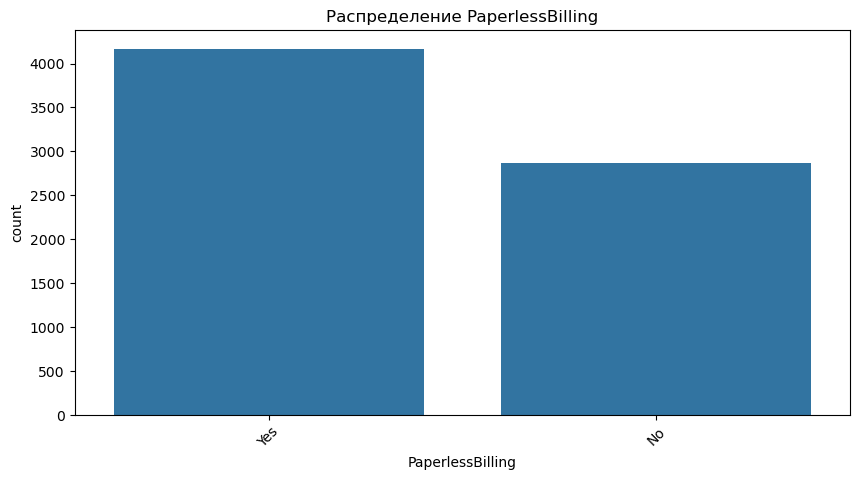

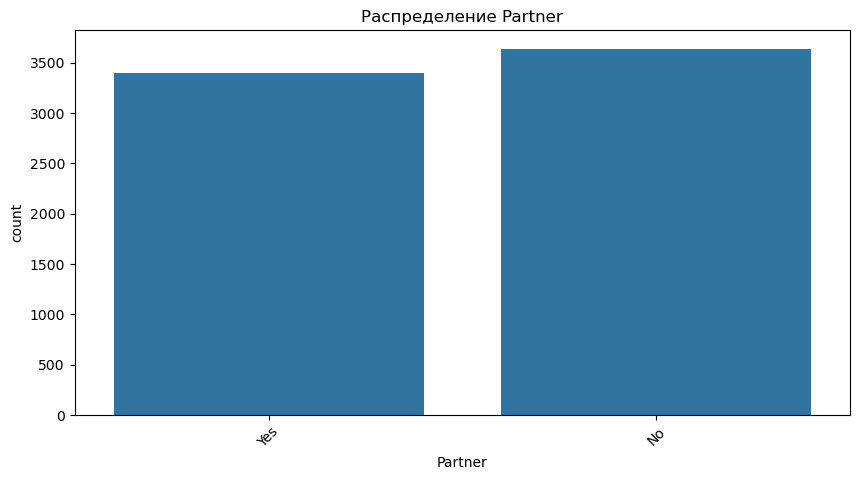

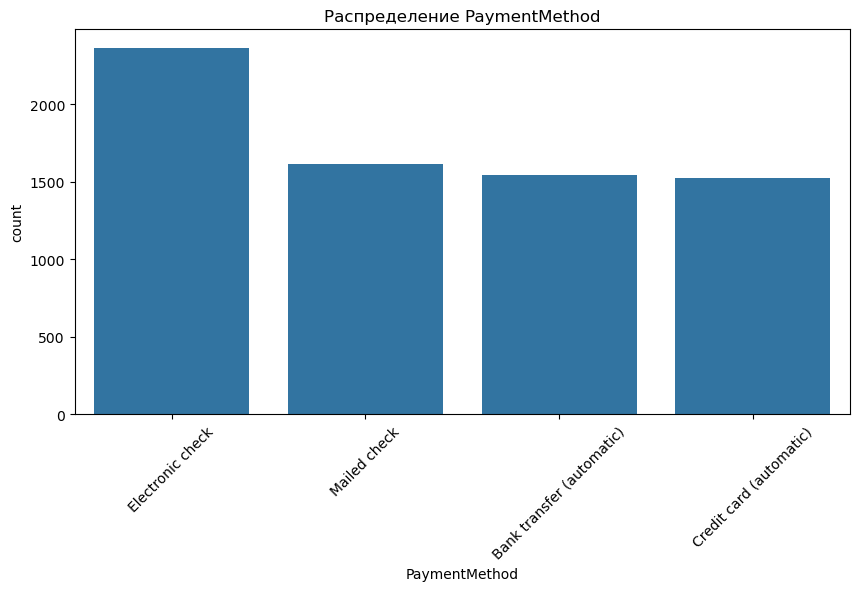

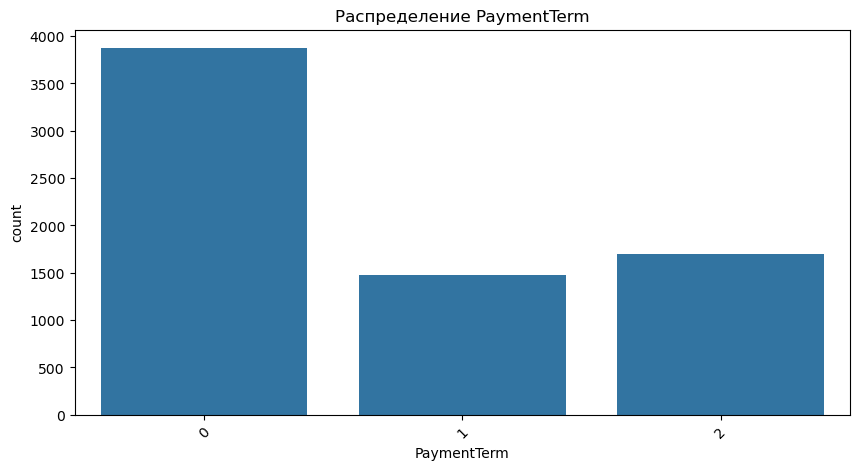

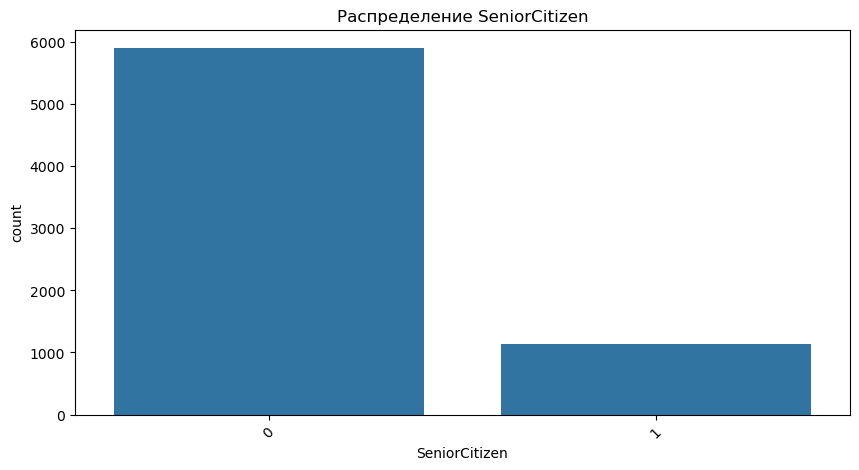

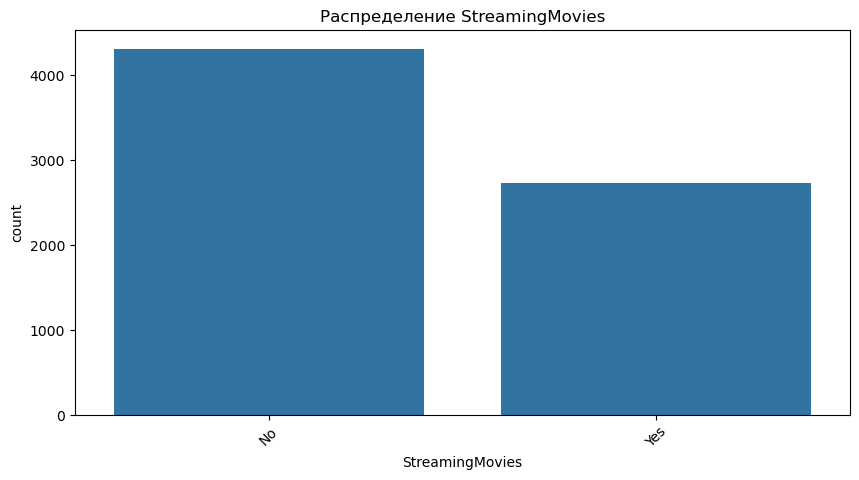

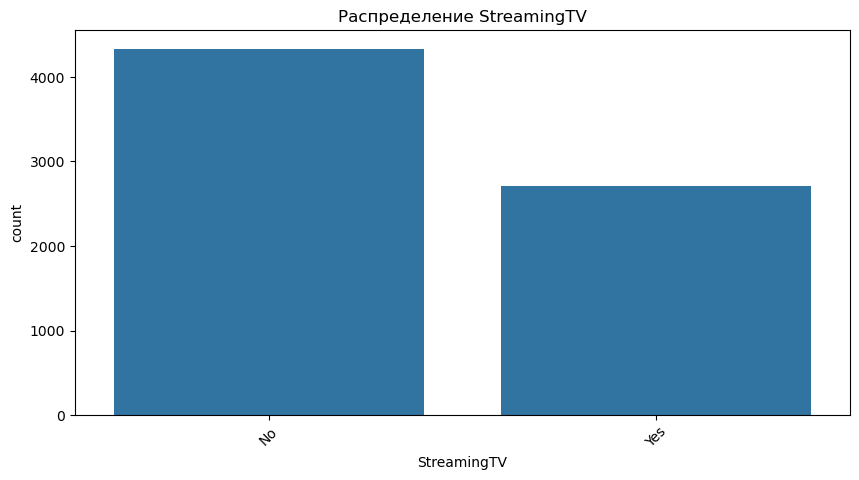

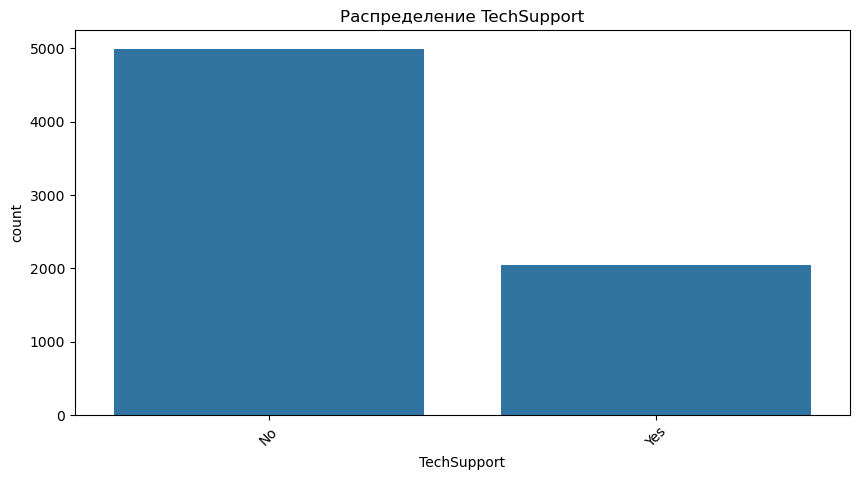

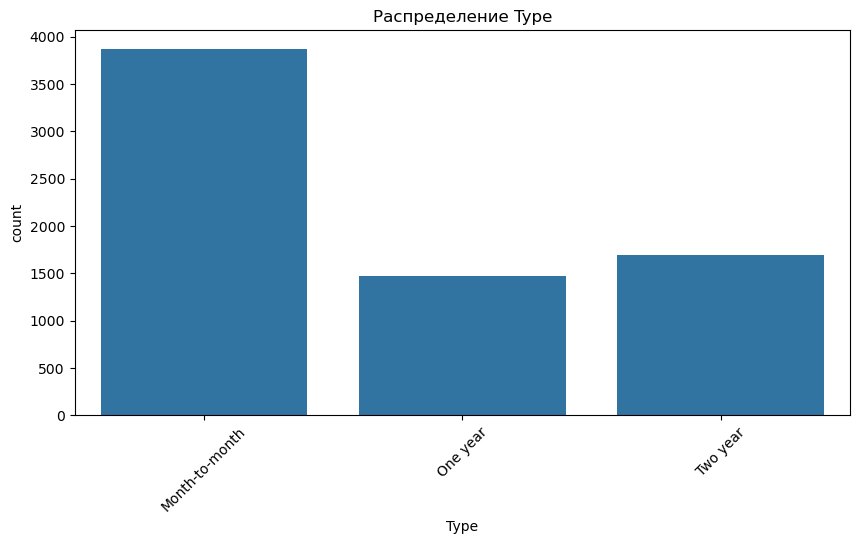

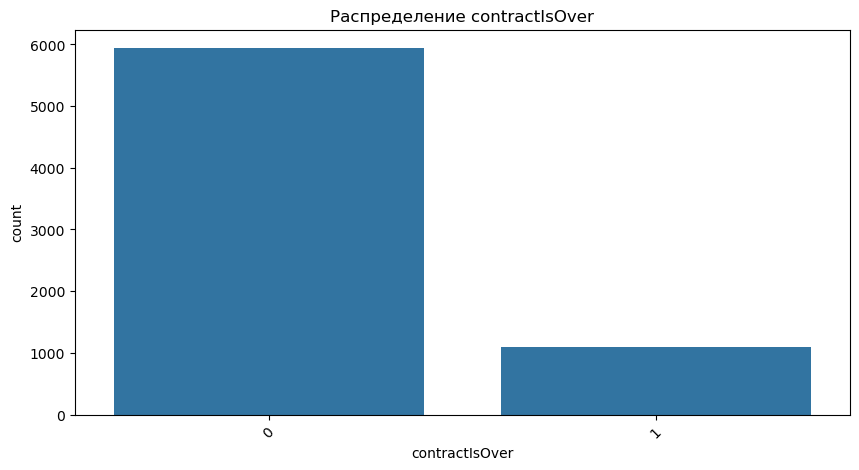

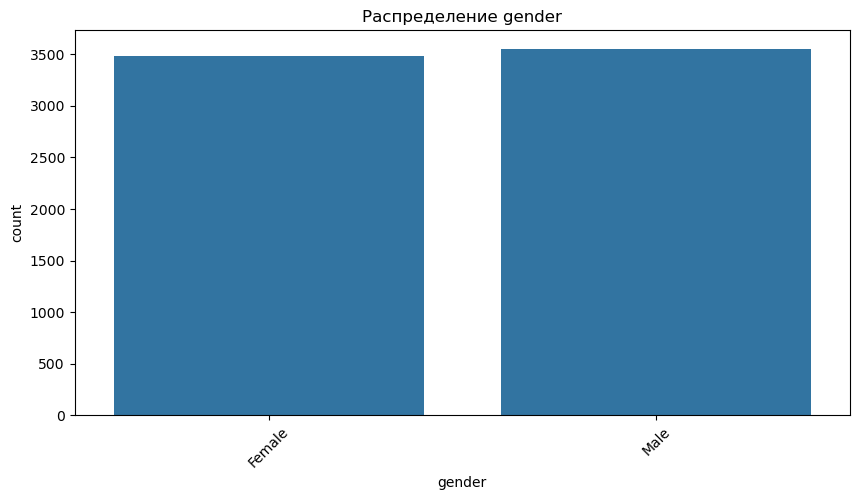

In [19]:
excluded_columns = ['customerID', 'BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges', 'ContractDays', 'ContractMonths', 'ContractYears', 'DailyCharges', 'YearlyCharges', 'NumServices']
filtered_columns = df.columns.difference(excluded_columns)

for col in filtered_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=df)
    plt.title(f'Распределение {col}')
    plt.xticks(rotation=45)
    plt.show()

Выводы по категориальным признакам:
1. Клиентов без детей больше, чем с детьми.
2. Клиентов без услуги антивирус больше, чем с ней.
3. В качестве типа подключения интернета чаще выбирают оптоволокно.
4. Клиентов без подключения телефона сразу к нескольким линиям незначительно больше, чем с одной линией.
5. Клиентов без облачного бэкапа больше, чем с ним.
6. Клиентов без блокировки опасных сайтов значительно больше, чем с ней.
7. Клиенты чаще выбирают электронные чеки.
8. Распределение клиентов с партнёром и без партнёра примерно одинаковое.
9. В качестве типа платежа чаще всего выбирают Электронный чек.
10. Клиентов не пенсионного возраста значительно больше, чем пенсионеров.
11. Клиентов с подключённым стримингом фильмов или ТВ примерно одинаковое количество.
12. Клиентов без техподдержки значительно больше, чем с ней.
13. Чаще всего клиенты выбирают оплату от месяца к месяцу.
14. Распределение полов примерно одинаковое.

Рассмотрим корреляцию между признаками и целевым признаком.

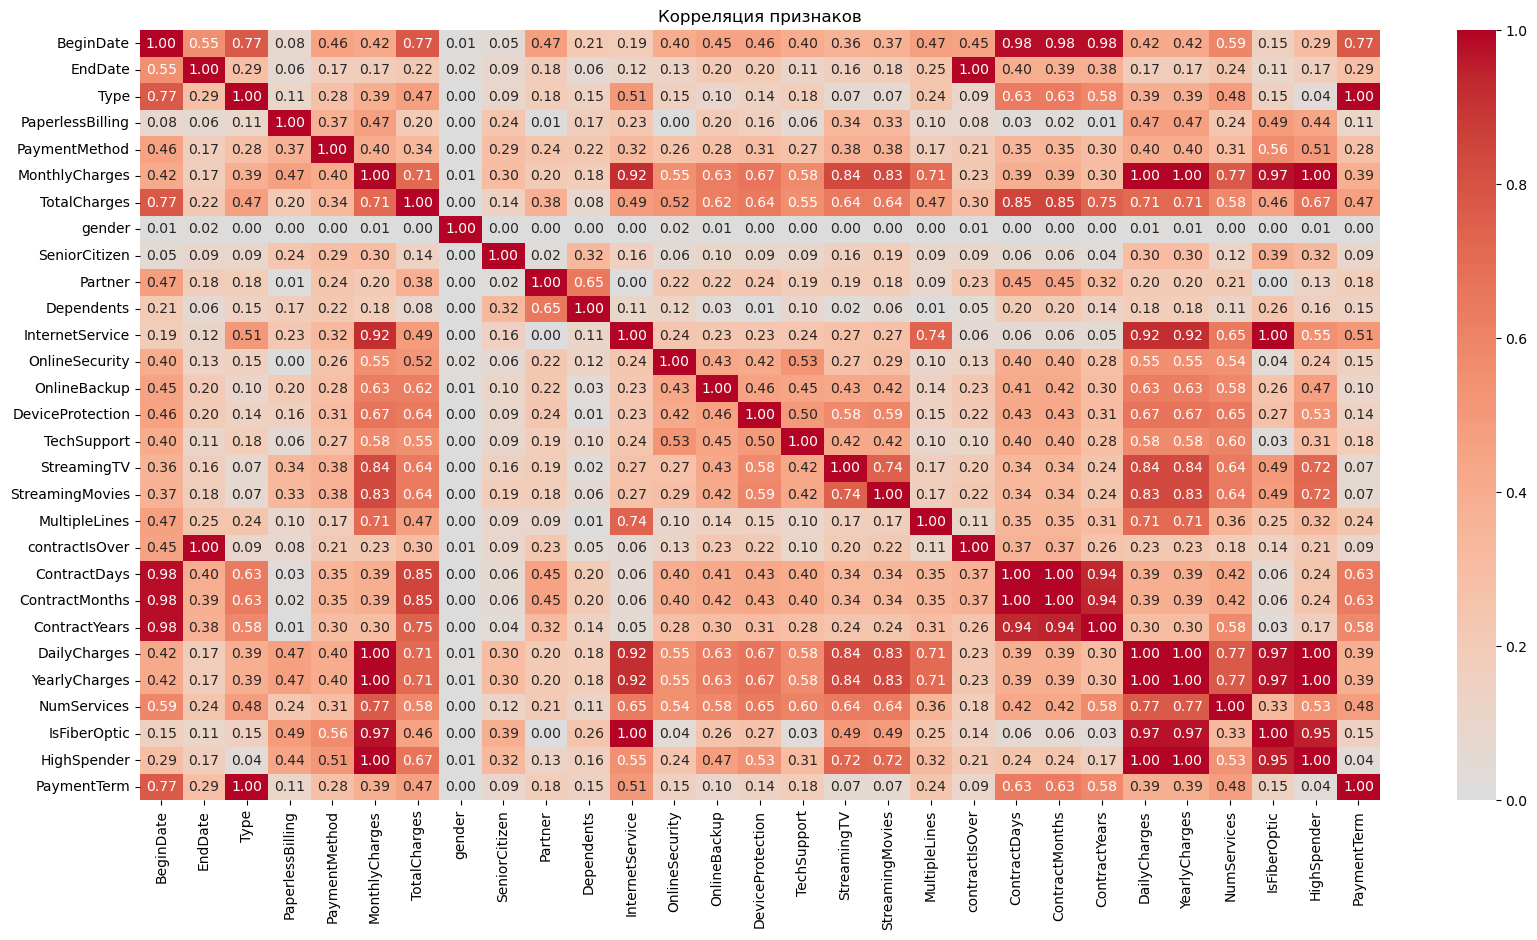

In [20]:
df_corr = df.drop(columns=['customerID'])

interval_columns = ['MonthlyCharges', 'TotalCharges', 'ContractDays',
                    'ContractMonths', 'ContractYears', 'DailyCharges',
                    'YearlyCharges', 'NumServices']

phik_corr = df_corr.phik_matrix(interval_cols=interval_columns)

plt.figure(figsize=(20, 10))
sns.heatmap(phik_corr, annot=True, fmt='.2f', center=0, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

- Есть мультиколлинеарность между `EndDate` и целевым признаком `contractIsOver`. Удалим `EndDate`.
- Есть мультиколлинеарность между `ContractMonths` и `ContractDays`. Удалим `ContractMonths` и `ContractYears`.
- Есть мультиколлинеарность между `MonthlyCharges` и `TotalCharges`. Удалим `MonthlyCharges` и `YearlyCharges`.
- Остальные признаки имеют не сильную корреляцию с целевым признаком.

In [21]:
df = df.drop(['EndDate', 'ContractMonths', 'ContractYears', 'DailyCharges', 'YearlyCharges'], axis=1)

### 5. Подготовка данных

Разделим данные на обучающую и тестовую выборки.

In [22]:
features = df.drop(['customerID', 'BeginDate', 'contractIsOver'], axis=1)
target = df['contractIsOver']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5282, 22) (1761, 22) (5282,) (1761,)


In [23]:
features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDays,NumServices,IsFiberOptic,HighSpender,PaymentTerm
4602,Two year,Yes,Mailed check,26.10,1748.70,Female,0,No,No,No,...,No,No,No,No,Yes,2041,0,0,0,2
3837,One year,Yes,Electronic check,105.65,665.60,Female,0,No,No,Fiber optic,...,Yes,Yes,Yes,Yes,No,184,5,1,1,1
7035,Month-to-month,Yes,Bank transfer (automatic),78.70,1585.02,Male,0,No,No,Fiber optic,...,No,No,Yes,No,No,580,1,1,1,0
1849,Month-to-month,Yes,Electronic check,45.55,552.07,Male,0,No,No,DSL,...,No,No,No,No,No,365,0,0,0,0
70,Month-to-month,No,Mailed check,49.05,52.48,Male,0,No,No,DSL,...,No,Yes,No,No,No,31,1,0,0,0


Анализ дисбаланса классов.

In [24]:
target.value_counts(normalize=True)

contractIsOver
0    0.843675
1    0.156325
Name: proportion, dtype: float64

Активые клиенты - около 85%, ушедших - 15%. Данные несбалансированы. Модель будет лучше обучаться на активных клиентах.

In [25]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'ContractDays', 'NumServices']
categorical_features = features.columns.difference(numeric_features)

In [26]:
#Код ментора
categorical_features

Index(['Dependents', 'DeviceProtection', 'HighSpender', 'InternetService',
       'IsFiberOptic', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity',
       'PaperlessBilling', 'Partner', 'PaymentMethod', 'PaymentTerm',
       'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport',
       'Type', 'gender'],
      dtype='object')

Создадим пайплайн для предобработки данных.

In [27]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### 6. Обучение моделей

Пайплайны для логистической регрессии и XGBoost.

In [28]:
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=RANDOM_STATE))
])

Параметры для поиска лучших гиперпараметров.

In [29]:
logistic_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__max_iter': [100, 200, 300]
}

xgb_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3]
}

Обучение модели логистической регрессии.

In [30]:
grid_logistic = GridSearchCV(logistic_pipeline, param_grid=logistic_params, cv=5, scoring='roc_auc')

grid_logistic.fit(features_train, target_train)

best_logistic_model = grid_logistic.best_estimator_

print(f"Лучшая модель: {best_logistic_model}")
print(f"ROC-AUC: {grid_logistic.best_score_}")

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'ContractDays',
                                                   'NumServices']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                               

ROC-AUC для логистической регрессии - 0.77.

Обучение модели XGBoost.

In [31]:
grid_xgb = GridSearchCV(xgb_pipeline, param_grid=xgb_params, cv=5, scoring='roc_auc')

grid_xgb.fit(features_train, target_train)

best_xgb_model = grid_xgb.best_estimator_

print(f"Лучшая модель: {best_xgb_model}")
print(f"ROC-AUC: {grid_xgb.best_score_}")

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'ContractDays',
                                                   'NumServices']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                               

ROC-AUC для XGBoost - 0.90.

Возьмём XGBoost в качестве лучшей модели. Проверим её на тестовой выборке.

In [32]:
final_pred_proba = best_xgb_model.predict_proba(features_test)[:, 1]
final_roc_auc = roc_auc_score(target_test, final_pred_proba)

print(f"ROC-AUC на тестовой выборке: {final_roc_auc}")

final_pred = best_xgb_model.predict(features_test)
final_accuracy = accuracy_score(target_test, final_pred)

print(f"Accuracy на тестовой выборке: {final_accuracy}")

ROC-AUC на тестовой выборке: 0.9042431748424963
Accuracy на тестовой выборке: 0.922771152754117


Построим график ROC-AUC для лучшей модели.

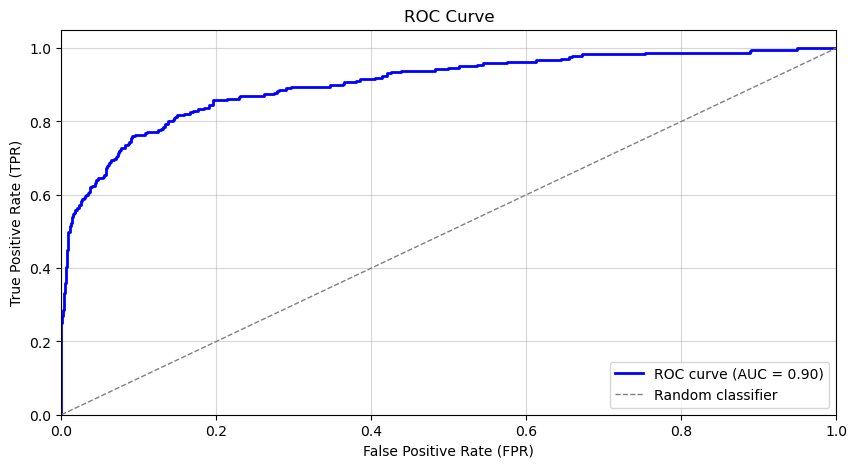

In [33]:
fpr, tpr, thresholds = roc_curve(target_test, final_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

Проведём анализ важности признаков.

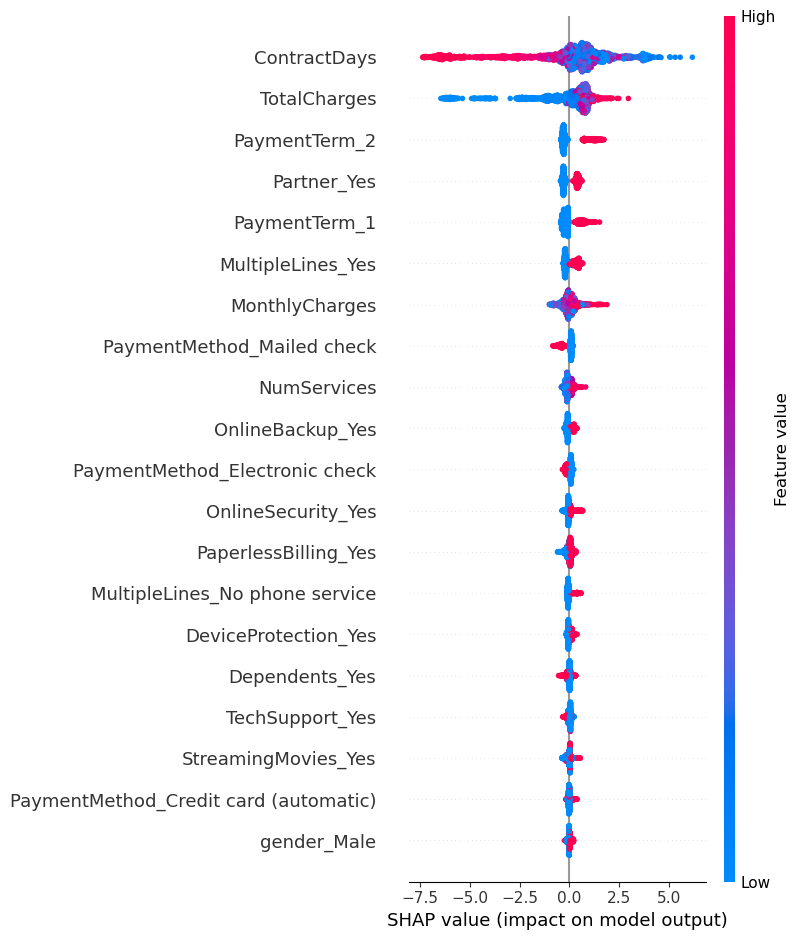

In [34]:
preprocessor.fit(features_train)

X_train_transformed = preprocessor.transform(features_train)
X_test_transformed = preprocessor.transform(features_test)

numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(preprocessor.transformers_[1][2])

feature_names = list(numeric_features) + list(categorical_features)

explainer = shap.Explainer(best_xgb_model.named_steps['classifier'], X_train_transformed)

shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

In [35]:
best_xgb_model.named_steps['classifier']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=130125, ...)

Самое большое влияние на целевой признак оказывают новые созданные признаки: `TotalCharges`, `ContractDays`.

1. Чем больше общие затраты за всё время (TotalCharges), тем больше вероятность, что клиент останется.
2. Чем долгосрочнее договор (ContractDays), тем больше вероятность, что клиент останется.

Построим матрицу ошибок.

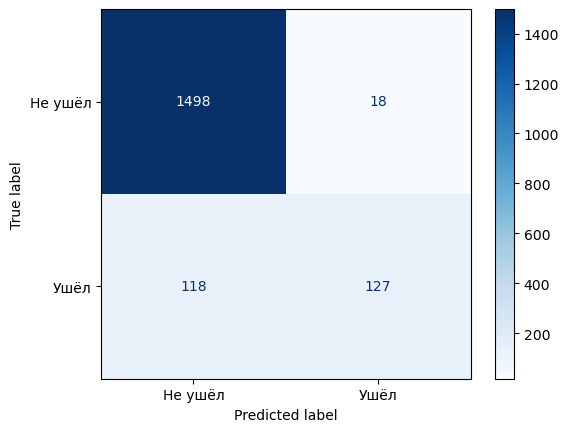

In [36]:
conf_matrix = confusion_matrix(target_test, final_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Не ушёл', 'Ушёл'])
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()

1 - клиент ушёл, 0 - клиент остался. Предсказания модели:
- Модель правильно предсказала, что 1498 клиентов останутся.
- Модель правильно предсказала, что 127 клиента уйдут.
- Модель ошиблась в 118 случае, предсказав, что клиент останется, но он ушёл.
- Модель ошиблась в 18 случаях, предсказав, что клиент уйдёт, но он остался.

### 8. Выводы и рекомендации

<b>Список признаков, участвующих в обучении модели и их предобработка:</b> <br>
Я использовал все признаки, кроме `customerID`, `BeginDate`, `EndDate`. <br>
Также были добавлены новые признаки: `ContractDays`, `ContractMonths`, `ContractYears`, `DailyCharges`, `YearlyCharges`, `NumServices`, `IsFiberOptic`, `HighSpender`, `PaymentTerm`. <br>
Числовые признаки были отмасштабированы, категориальные закодированы методом OneHotEncoder. <br>
<br>
Больше всего влияют на целевой признак `TotalCharges` и `ContractDays`. <br>

<b>Итоговая модель:</b> <br>
- XGBoost. <br>
- learning_rate=0.3, max_depth=3, n_estimators=200, random_state=130125. <br>
- ROC-AUC: 0.90, Accuracy: 0.92. <br>

<b>Рекомендации заказчику</b>: <br>
- Следует обратить внимание на клиентов с низкими общими затратами за всё время, месячными затратами и коротким сроком договора, так как они уходят чаще всего. <br>
- Стоит уделить внимание клиентам, которые не пользуются дополнительными услугами, так как они также уходят чаще. <br>
- Предлагать акции и скидки на дополнительные услуги, чтобы удержать клиентов. <br>
- Предлагать скидки на долгосрочные договоры, так как клиенты с долгосрочными договорами уходят реже. <br>